In [ ]:
import numpy as np #linear algebra
import pandas as pd #data preprocessing
import os

from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU
import cv2
from tqdm import tqdm
import random
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
dataframe = pd.read_csv('/content/drive/MyDrive/dataset/age_gender.csv')
dataframe.head(10)

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...
5,1,2,0,20161220144957407.jpg.chip.jpg,195 198 200 200 198 198 199 199 198 197 197 19...
6,1,2,0,20161220145040127.jpg.chip.jpg,208 216 217 219 222 223 222 221 220 220 221 22...
7,1,2,0,20170109191125532.jpg.chip.jpg,99 142 169 177 179 181 183 186 187 186 191 190...
8,1,2,0,20161219222749039.jpg.chip.jpg,127 127 133 140 143 148 152 157 160 165 172 17...
9,1,2,0,20170109191209991.jpg.chip.jpg,199 211 211 214 216 216 219 221 222 224 219 21...


In [ ]:
class CustomDataGen(tf.keras.utils.Sequence):

    def __init__(self, df,
                 batch_size = 32,
                 input_size=(48,48,3),
                 shuffle=True,
                 data_augmentation = False):
        self.df = df
        self.batch_size = batch_size
        self.input_size = input_size
        self.var = 1



        self.images = []
        self.gender_labels = []

        for index, row in tqdm(df.iterrows()):
            image = np.fromstring(row['pixels'], sep = ' ', dtype = np.uint8).reshape((48,48))
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

            self.images.append(image)

            self.gender_labels.append(row['gender'])


        self.images = np.array(self.images)
        self.gender_labels = np.array(self.gender_labels).astype(np.float32)

        p = np.random.permutation(len(self.gender_labels))
        self.images = self.images[p]
        self.gender_labels = self.gender_labels[p]

        self.n = len(self.df)


    def __getitem__(self, index):
        images = []

        for i in range(self.batch_size):
            image = self.images[index * self.batch_size + i]


            images.append(image)

        s = slice(self.batch_size * index, (index + 1) * self.batch_size)
        return np.array(images), (self.gender_labels[s])

    def __len__(self):

        return self.n // self.batch_size

    def on_epoch_end(self):

        #Random permutation
        p = np.random.permutation(len(self.gender_labels))
        self.images = self.images[p]
        self.gender_labels = self.gender_labels[p]

In [ ]:
msk = np.random.rand(len(dataframe)) < 0.8
train = dataframe[msk]
val = dataframe[~msk]

train_dataset = CustomDataGen(train)
val_dataset = CustomDataGen(val)

def build_model(input_shape = (48,48,3)):

    i = tf.keras.layers.Input(input_shape, dtype = tf.uint8)
    x = tf.cast(i, tf.float32)
    x = tf.keras.applications.vgg16.preprocess_input(x)

    backbone = tf.keras.applications.vgg16.VGG16(
                include_top=False, weights='imagenet',
                input_tensor=x
            )
    output_layer = backbone.get_layer("block5_conv3").output

    def build_gender_branch(input_tensor):
        x = tf.keras.layers.Dense(1024, activation = LeakyReLU(alpha=0.3))(input_tensor)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'gender_output')(x)

        return x

    x = tf.keras.layers.Flatten()(output_layer)
    output_gender = build_gender_branch(x)
    model = tf.keras.Model(i, output_gender)

    return model

18985it [00:06, 2736.11it/s]
4720it [00:00, 8337.17it/s]


In [ ]:
def build_model(input_shape = (48,48,3)):

    i = tf.keras.layers.Input(input_shape, dtype = tf.uint8)
    x = tf.cast(i, tf.float32)
    x = tf.keras.applications.vgg16.preprocess_input(x)

    backbone = tf.keras.applications.vgg16.VGG16(
                include_top=False, weights='imagenet',
                input_tensor=x
            )
    output_layer = backbone.get_layer("block5_conv3").output

    def build_gender_branch(input_tensor):
        x = tf.keras.layers.Dense(1024, activation = LeakyReLU(alpha=0.3))(input_tensor)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'gender_output')(x)

        return x

    x = tf.keras.layers.Flatten()(output_layer)
    output_gender = build_gender_branch(x)
    model = tf.keras.Model(i, output_gender)

    return model

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 tf.cast (TFOpLambda)        (None, 48, 48, 3)         0         
                                                                 
 tf.__operators__.getitem (S  (None, 48, 48, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 48, 48, 3)        0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928  

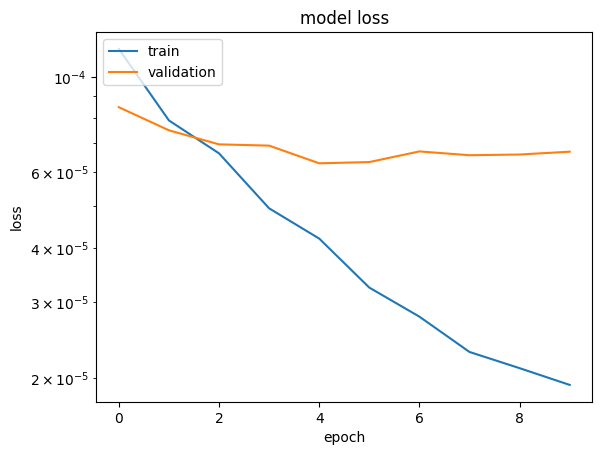

In [ ]:
EPOCHS = 10
BATCH_SIZE = 32

model = build_model()
model.summary()

model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4), loss = ['mse', 'binary_crossentropy'], loss_weights = [0.001,0.5,0.5],
              metrics = {'gender_output': 'accuracy'})

plateau = tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_loss', factor=0.3, patience=2, verbose = 1
)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                                      patience=5)
save_best = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/dataset/age_gender.csv', monitor='val_loss', save_best_only=True,
                                            mode='min', save_weights_only = True)


history = model.fit(train_dataset,
            epochs=EPOCHS,
            batch_size = BATCH_SIZE,
            validation_data=val_dataset,
            callbacks = [es, save_best, plateau])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.yscale('log')
plt.show()


In [ ]:
model.load_weights('/content/drive/MyDrive/dataset/age_gender.csv')

In [ ]:
model.evaluate(val_dataset)

147/147 [==============================] - 2s 13ms/step - loss: 6.3190e-05 - accuracy: 0.9160


[6.318958185147494e-05, 0.9160289168357849]

1/1 [==============================] - 0s 207ms/step


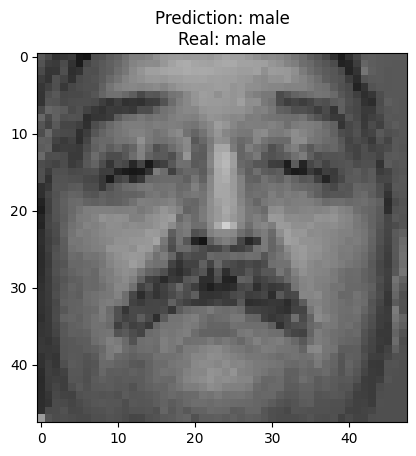

In [ ]:
name_genders = ['male', 'female']

images, labels = val_dataset[50]
index = 0

p = model.predict(images)

gender_predictions = tf.where(p > 0.5, 1, 0)
plt.title(f'Prediction: {name_genders[gender_predictions[index][0]]}\n'+
         f'Real: {name_genders[int(labels[index])]}')
plt.imshow(images[index])
plt.show()